In [1]:
from aemulusnu_massfunction.emulator import *
from aemulusnu_massfunction.fisher_utils import *

loading emulator from /home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction/emulator.pkl


In [2]:
emulator = AemulusNu_HMF_Emulator()

loading emulator from /home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction/emulator.pkl


In [3]:
class AemulusNu_HMF_Emulator_old(MassFunc):
    """
    """
    name = 'AemulusNu_HMF_Emulator'

    def __init__(self, *,
                 emulator_loc= package_path+"/emulator.pkl",
                 mass_def="200m",
                 mass_def_strict=True):
        super().__init__(mass_def=mass_def, mass_def_strict=mass_def_strict)
        self.ComputedParams = {}
        print('loading emulator from',emulator_loc)
        with open(emulator_loc, 'rb') as f:
            self.model, self.in_scaler, self.out_scaler, self.likelihood = pickle.load(f)
            self.model.eval()
            self.likelihood.eval()



    def _check_mass_def_strict(self, mass_def):
        return mass_def.Delta == "fof"

    def _setup(self):
        self.params = {'d':-1, 'e':-1, 'f':-1, 'g':-1}

    def set_params(self, params):
        self.params = dict(zip(self.params.keys(), params))

    def predict_params(self, cosmology, z):
        """
        Parameters:
            - cosmology (dict): A dictioniary containing the cosmological parameters
                - 10^9 As: As * 10^9
                - ns: Spectral index
                - H0: Hubble parameter in [km/s/Mpc]
                - w0: Dark Energy Equation fo State
                - ombh2: Ω_b h^2
                - omch2: Ω_m h^2
                - nu_mass_ev: Neutrino mass sum in [eV]
            - z (float): Redshift to evaluate dn/dM at
        Returns:
            - tinker parameters(dict): A dictionary containing the predicted tinker
                                       parameters from the HMF emulator.
                                       {'d':d, 'e':e, 'f':f, 'g':g}
        """

        a = redshiftToScale(z)


        curr_cosmo_values = get_cosmo_vals(cosmology)
        X = self.in_scaler.transform(np.array([curr_cosmo_values + [a]]))
        if(tuple(X[0].tolist()) in self.ComputedParams):
            return self.ComputedParams[tuple(X[0].tolist())]

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            predictions = self.likelihood(self.model(torch.from_numpy(X).float()))
            mean = self.out_scaler.inverse_transform(predictions.mean.numpy())
        self.ComputedParams[tuple(X[0].tolist())] = dict(zip(['d','e','f','g'], mean[0]))
        return self.ComputedParams[tuple(X[0].tolist())]


    def _get_fsigma(self, cosmo, sigM, a, lnM):
        h = cosmo['h']
        cosmology = {'10^9 As': 10**9 *cosmo['A_s'],
                      'ns': cosmo['n_s'],
                      'H0': cosmo['h']*100,
                      'w0': cosmo['w0'],
                      'ombh2': cosmo['Omega_b']*h**2,
                      'omch2': cosmo['Omega_c']*h**2,
                      'nu_mass_ev': sum(cosmo['m_nu']),}

        cosmo_vals = tuple(get_cosmo_vals(cosmology))


        tinker_params = self.predict_params(cosmology, scaleToRedshift(a))
        return f_G(a, np.exp(lnM), sigM, **tinker_params)


In [4]:
old_emulator = AemulusNu_HMF_Emulator_old(emulator_loc='/home/users/delon/delon/aemulusnu_massfunction.bak.2024-01-12/GP_loBox_n50_0_1400.pkl')

loading emulator from /home/users/delon/delon/aemulusnu_massfunction.bak.2024-01-12/GP_loBox_n50_0_1400.pkl


In [5]:
fiducial_cosmology

{'10^9 As': 2.1,
 'ns': 0.9649,
 'H0': 67.36,
 'w0': -1,
 'ombh2': 0.02237,
 'omch2': 0.12,
 'nu_mass_ev': 0.06}

In [6]:
fiducial_log10_rel_step_size

{'10^9 As': -2.6,
 'ns': -4,
 'H0': -2.3,
 'w0': -2.3,
 'ombh2': -2.6,
 'omch2': -2.3,
 'nu_mass_ev': -2.3}

0
1
2
3
4


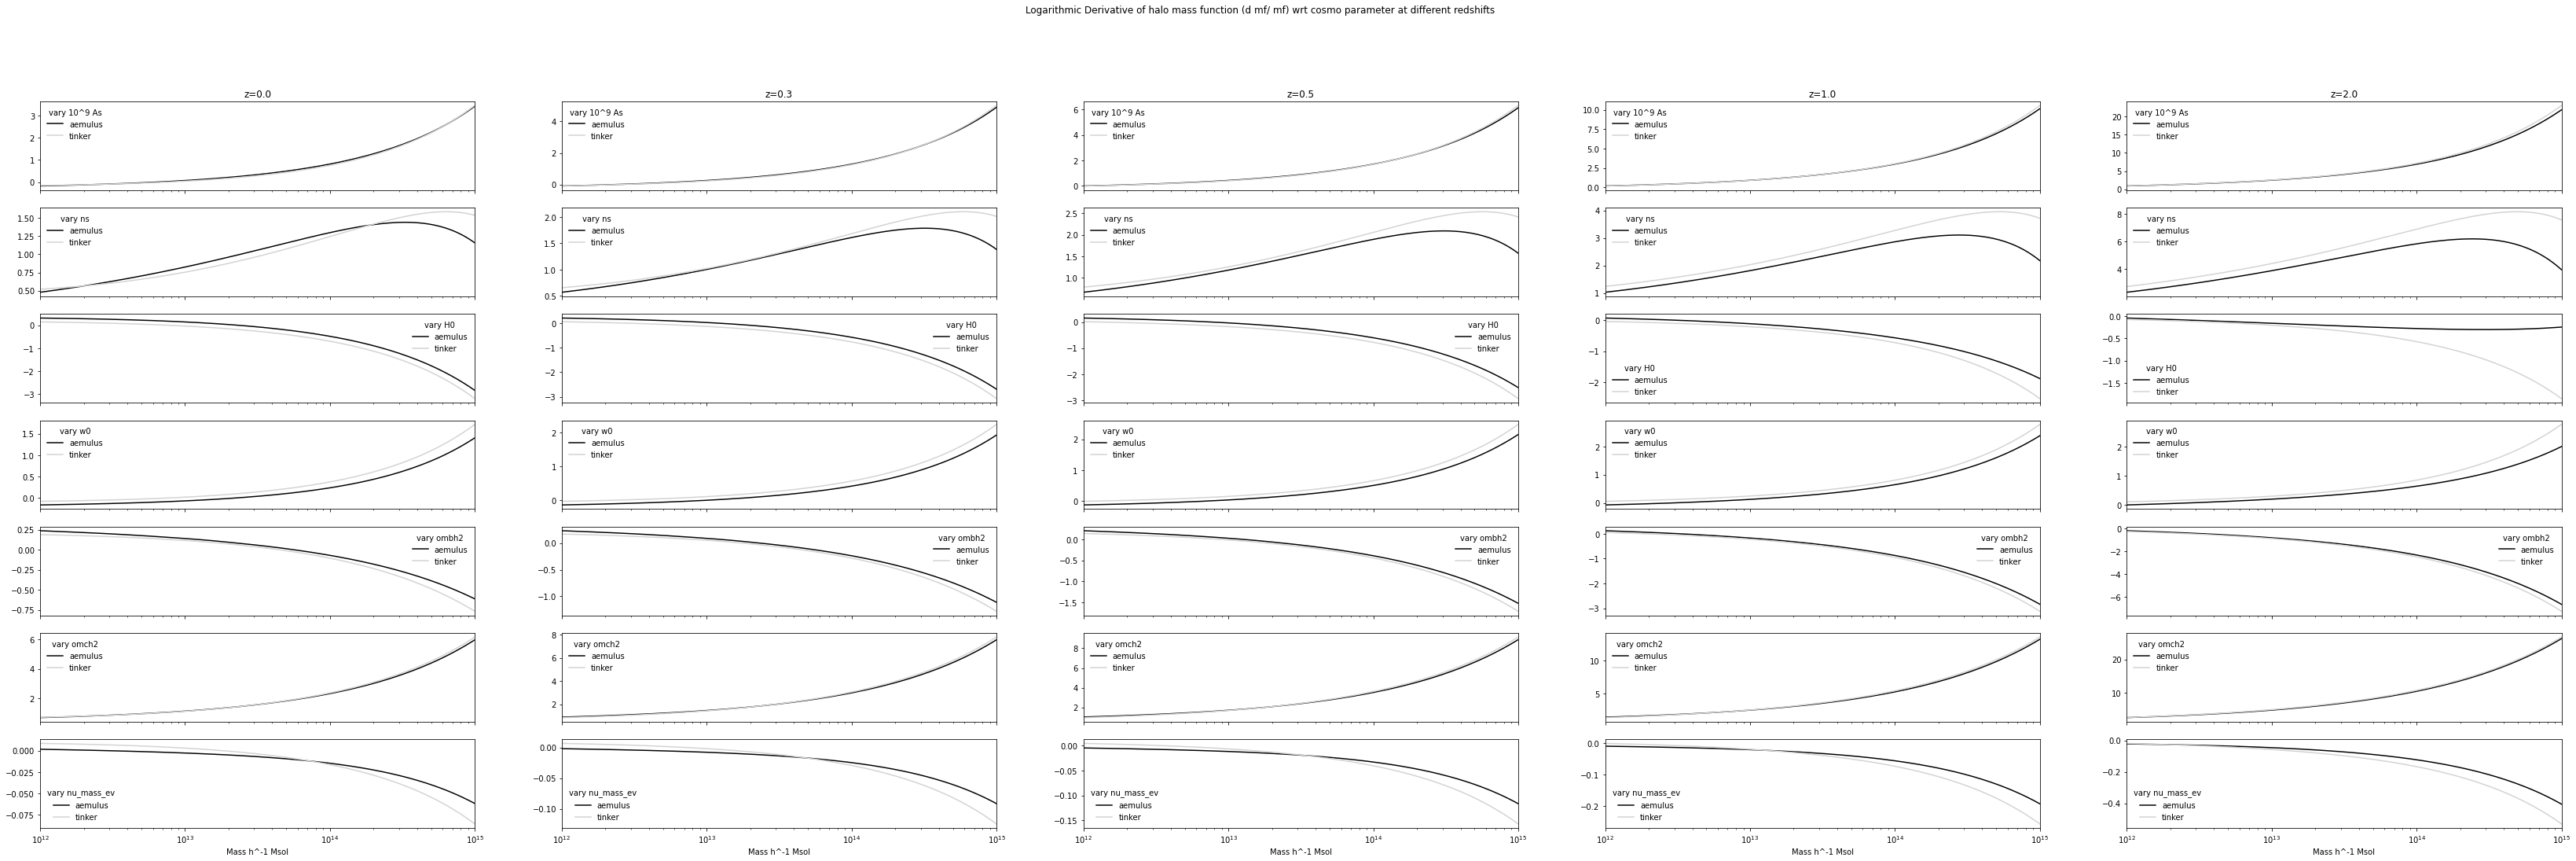

In [7]:
zss = [0.0, 0.3, 0.5, 1.0, 2.0]

cutoffs = [1e15, 1e15, 1e15, 7e14,1e14]
fig, meta_axs = plt.subplots(7,len(zss), figsize=(11.5* len(zss), 17), sharex=True)
fig.suptitle('Logarithmic Derivative of halo mass function (d mf/ mf) wrt cosmo parameter at different redshifts')
for j,z_curr in enumerate(zss):
    print(j)

    axs = meta_axs[:,j]
    for i,varied_param in enumerate(fiducial_cosmology.keys()):
        step = np.abs(fiducial_cosmology[varied_param]) * 10**fiducial_log10_rel_step_size[varied_param]
        

        cosmology_plus = fiducial_cosmology.copy()
        cosmology_plus[varied_param] +=  step
        cosmo_plus = get_ccl_cosmology(tuple(get_cosmo_vals(cosmology_plus)))

        cosmology_minus = fiducial_cosmology.copy()
        cosmology_minus[varied_param] -=  step
        cosmo_minus = get_ccl_cosmology(tuple(get_cosmo_vals(cosmology_minus)))

        M = 10**np.linspace(12, 15, 150)
        h = fiducial_cosmology['H0']/100

#         for mf,lbl, sty in zip([emulator, old_emulator, tinker08_hmf], ['curr','old', 'tinker'], ['k','r--','lightgrey']):
        for mf,lbl, sty in zip([emulator, tinker08_hmf], ['aemulus', 'tinker'], ['k','lightgrey']):

            dndm_plus = mf(cosmo_plus, M/h, redshiftToScale(z_curr))
            dndm_minus = mf(cosmo_minus, M/h, redshiftToScale(z_curr))
            dndm_dAs = (dndm_plus- dndm_minus)/(2*step)
            dndm_fid = mf(fiducial_ccl_cosmo,  M/h, redshiftToScale(z_curr))
        

            axs[i].plot(M, fiducial_cosmology[varied_param]*dndm_dAs/dndm_fid, sty,label=lbl)
            axs[i].legend(frameon=False, title='vary %s'%varied_param)
            axs[i].set_xscale('log')
#             axs[i].axhline(0, ls='--', color='k')
#             axs[i].axvline(cutoffs[j], ls='--', color='lightgrey')
            axs[i].set_xlim(1e12, 1e15)
    axs[0].set_title('z=%s'%z_curr)
    axs[-1].set_xlabel('Mass h^-1 Msol')
plt.savefig('old_vs_new.pdf')